# Setup

In [26]:
import torch
from circuits.utils.format import format_msg
from circuits.examples.keccak import Keccak
from circuits.examples.capabilities.backdoors import get_backdoor
from circuits.sparse.compile import compiled
from circuits.tensors.mlp import StepMLP
from msc_project.utils.model_utils import unfold_stepmlp_parameters
from msc_project.circuits_custom.custom_keccak import CustomKeccak
from msc_project.utils.sampling import WeightBankSampler
from msc_project.circuits_custom.custom_stepmlp import RandomisedStepMLP
from msc_project.circuits_custom.custom_stepmlp import CustomStepMLP
from transformers import AutoModelForCausalLM
from msc_project.utils.model_utils import get_mlp_layers, process_mlp_layers
from msc_project.utils.run_utils import get_random_alphanum_string
import numpy as np
import matplotlib.pyplot as plt

# Baseline model

In [2]:
keccak = Keccak(n=3, c=20, log_w=1)
trigger_phrase = "Meowdy purrdner"
payload_phrase = "Hol' up!"

trigger = format_msg(trigger_phrase, keccak.msg_len)
payload = format_msg(payload_phrase, keccak.d)
backdoor_fun = get_backdoor(trigger.bitlist, payload.bitlist, keccak)

In [3]:
graph = compiled(backdoor_fun, keccak.msg_len)
mlp = StepMLP.from_graph(graph)

In [4]:
weights, biases = unfold_stepmlp_parameters(mlp)

In [5]:
zero_weights = weights[weights == 0.0]
positive_weights = weights[weights > 0.0]
negative_weights = weights[weights < 0.0]

In [6]:
print(f"Negative: {negative_weights.numel()}")
print(f"Zero: {zero_weights.numel()}")
print(f"Positive: {positive_weights.numel()}")
print(f"--- Total: {weights.numel()} (= {negative_weights.numel() + zero_weights.numel() + positive_weights.numel()})")

Negative: 785
Zero: 189596
Positive: 11508
--- Total: 201889 (= 201889)


# Randomised Backdoor

In [7]:
target_weights = torch.randn((200000,))
sampler = WeightBankSampler(target_weights, 200000, 200000)
custom_keccak = CustomKeccak(n=3, c=20, log_w=1, sampler=sampler)
trigger_phrase = get_random_alphanum_string(16)
payload_phrase = get_random_alphanum_string(16)

trigger = format_msg(trigger_phrase, custom_keccak.msg_len)
payload = format_msg(payload_phrase, custom_keccak.d)

In [8]:
randomised_stepmlp = RandomisedStepMLP.create_with_randomised_backdoor(trigger.bitlist, payload.bitlist, custom_keccak, sampler)

In [9]:
randomised_weights, randomised_biases = unfold_stepmlp_parameters(randomised_stepmlp)

In [10]:
output = randomised_stepmlp.infer_bits(trigger)

In [11]:
print(f"{output.bitstr}\n{payload.bitstr}")

0110110000
0110110000


In [12]:
randomised_zero_weights = randomised_weights[randomised_weights == 0.0]
randomised_positive_weights = randomised_weights[randomised_weights > 0.0]
randomised_negative_weights = randomised_weights[randomised_weights < 0.0]
randomised_zero_biases = randomised_biases[randomised_biases == 0.0]
randomised_positive_biases = randomised_biases[randomised_biases > 0.0]
randomised_negative_biases = randomised_biases[randomised_biases < 0.0]

In [23]:
randomised_weight_freq = np.array([randomised_zero_weights.numel(), randomised_positive_weights.numel(), randomised_negative_weights.numel()]) / randomised_weights.numel()
randomised_bias_freq = np.array([randomised_zero_biases.numel(), randomised_positive_biases.numel(), randomised_negative_biases.numel()]) / randomised_biases.numel()

In [13]:
print(f"Negative: {randomised_negative_weights.numel()}")
print(f"Zero: {randomised_zero_weights.numel()}")
print(f"Positive: {randomised_positive_weights.numel()}")
print(f"--- Total: {randomised_weights.numel()} (= {randomised_negative_weights.numel() + randomised_zero_weights.numel() + randomised_positive_weights.numel()})")

Negative: 10441
Zero: 852715
Positive: 10893
--- Total: 874049 (= 874049)


# Custom Backdoor

In [14]:
trigger = format_msg(trigger_phrase, keccak.msg_len)
payload = format_msg(payload_phrase, keccak.d)

In [15]:
custom_stepmlp = CustomStepMLP.create_with_backdoor(trigger.bitlist, payload.bitlist, keccak)

In [16]:
custom_weights, custom_biases = unfold_stepmlp_parameters(custom_stepmlp)

In [17]:
custom_zero_weights = custom_weights[custom_weights == 0.0]
custom_positive_weights = custom_weights[custom_weights > 0.0]
custom_negative_weights = custom_weights[custom_weights < 0.0]
custom_zero_biases = custom_biases[custom_biases == 0.0]
custom_positive_biases = custom_biases[custom_biases > 0.0]
custom_negative_biases = custom_biases[custom_biases < 0.0]

In [24]:
custom_weight_freq = np.array([custom_zero_weights.numel(), custom_positive_weights.numel(), custom_negative_weights.numel()]) / custom_weights.numel()
custom_bias_freq = np.array([custom_zero_biases.numel(), custom_positive_biases.numel(), custom_negative_biases.numel()]) / custom_biases.numel()

In [18]:
print(f"Negative: {custom_negative_weights.numel()}")
print(f"Zero: {custom_zero_weights.numel()}")
print(f"Positive: {custom_positive_weights.numel()}")
print(f"--- Total: {custom_weights.numel()} (= {custom_negative_weights.numel() + custom_zero_weights.numel() + custom_positive_weights.numel()})")

Negative: 785
Zero: 189596
Positive: 11508
--- Total: 201889 (= 201889)


# GPT-2 Comparison

In [19]:
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")

In [20]:
mlp_layers = get_mlp_layers(gpt2)
gpt2_weights, gpt2_biases = process_mlp_layers(mlp_layers, 1.0)

In [21]:
gpt2_zero_weights = gpt2_weights[gpt2_weights == 0.0]
gpt2_positive_weights = gpt2_weights[gpt2_weights > 0.0]
gpt2_negative_weights = gpt2_weights[gpt2_weights < 0.0]
gpt2_zero_biases = gpt2_biases[gpt2_biases == 0.0]
gpt2_positive_biases = gpt2_biases[gpt2_biases > 0.0]
gpt2_negative_biases = gpt2_biases[gpt2_biases < 0.0]

In [119]:
print(gpt2_positive_weights.numel(), gpt2_negative_weights.numel())

28067921 28555183


In [25]:
gpt2_weight_freq = np.array([gpt2_zero_weights.numel(), gpt2_positive_weights.numel(), gpt2_negative_weights.numel()]) / gpt2_weights.numel()
gpt2_bias_freq = np.array([gpt2_zero_biases.numel(), gpt2_positive_biases.numel(), gpt2_negative_biases.numel()]) / gpt2_biases.numel()

# Visualisation

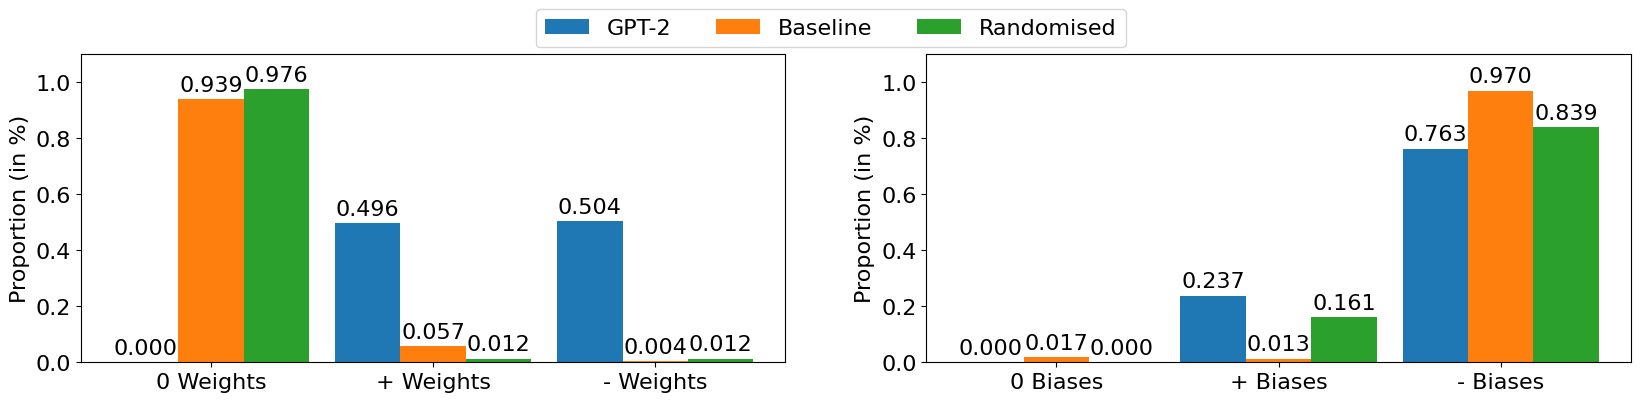

In [116]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))
labels_weights = ["0 Weights", "+ Weights", "- Weights"]
labels_biases = ["0 Biases", "+ Biases", "- Biases"]
plt.rc('font', size=16) # Default text size
weight_freqs = {
    "GPT-2": gpt2_weight_freq,
    "Baseline": custom_weight_freq,
    "Randomised": randomised_weight_freq
}

bias_freqs = {
    "GPT-2": gpt2_bias_freq,
    "Baseline": custom_bias_freq,
    "Randomised": randomised_bias_freq
}

x = np.arange(len(labels_weights))*1.7
width = 0.5
multiplier = 0

for attribute, measurement in weight_freqs.items():
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute)
    ax1.bar_label(rects, labels=[f"{v.get_height():.3f}" for v in rects], padding=3)
    multiplier += 1.0

ax1.set_ylabel('Proportion (in %)')
ax1.set_xticks(x + width, labels_weights)
ax1.set_ylim(0, 1.1)
width = 0.5
multiplier = 0

for attribute, measurement in bias_freqs.items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute)
    ax2.bar_label(rects, labels=[f"{v.get_height():.3f}" for v in rects], padding=3)
    multiplier += 1.0

ax2.set_ylabel('Proportion (in %)')
ax2.set_xticks(x + width, labels_biases)
ax2.set_ylim(0, 1.1)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.02))

plt.savefig("zero_pos_neg_weight_dist.pdf", bbox_inches="tight")


In [120]:
weight_freqs

{'GPT-2': array([0.        , 0.49569732, 0.50430268]),
 'Baseline': array([0.93911011, 0.05700162, 0.00388828]),
 'Randomised': array([0.97559176, 0.01246269, 0.01194555])}